In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
project_path = "/content/drive/MyDrive/Areas/Going Pro/Diplo Deep Learning/final_nlp/"

Mounted at /content/drive/


In [5]:
! cp "/content/drive/MyDrive/Areas/Going Pro/Diplo Deep Learning/final_nlp/datagen.py" ./
! cp "/content/drive/MyDrive/Areas/Going Pro/Diplo Deep Learning/final_nlp/dataaug.py" ./

In [7]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 549 kB/s 


# Modelo CNN con generador, embedings de smiles y data-augmentation

In [8]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [9]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [10]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [11]:
df = pd.read_csv(project_path + 'data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [12]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [13]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [14]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [15]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1ccccc1COc1cccc(-n2c(=O)oc(OCC)n2)c1
c1c(COc2cccc(-n3nc(OCC)oc3=O)c2)cccc1
O=c1n(-c2cccc(OCc3ccccc3)c2)nc(OCC)o1
c1cc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)ccc1
c1(OCc2ccccc2)cccc(-n2nc(OCC)oc2=O)c1
c1(=O)oc(OCC)nn1-c1cccc(OCc2ccccc2)c1
c1c(COc2cccc(-n3c(=O)oc(OCC)n3)c2)cccc1
c1ccc(OCc2ccccc2)cc1-n1c(=O)oc(OCC)n1
c1cc(COc2cc(-n3nc(OCC)oc3=O)ccc2)ccc1
c1cc(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)c1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [16]:
from datagen import DataGenerator

In [17]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [18]:
len(dgen) * dgen.batch_size

5664

In [19]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
len(X_train), len(y_train), len(X_test)

(4530, 4530, 1133)

In [24]:
X_train

array(['COc1ccc(C(F)(F)F)c[n+]1C.F[B-](F)(F)F',
       '[Cl-].[Cl-].c1cc[n+](COC[n+]2ccccc2)cc1',
       'CCOC(=O)C1=C(C)Oc2nc3c(c(N)c2[C@H]1c1ccccc1)CCCC3', ...,
       'O=[N+]([O-])c1ccccc1-c1nnc(Nc2ncccn2)o1',
       'COc1cc2c(cc1O)CCC(C)(CCNCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2',
       'CN(C)Cc1ccc(CSCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [27]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
# A la data de validación/test no se le realiza data augmentation porque necesitamos trabajar con datos reales
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [26]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [28]:
X_b.shape

(109, 227)

# Network Model

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [30]:
# Implementar modelo de TextCNN
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = Embedding(vocab_size + 1, embedding_size)(input_x)
    pooled_outputs = []
    max_pool_div = 4
    for filter_size in filter_sizes:
        conv = Conv1D(num_filters, filter_size, padding='same', activation='relu')(embedding)
        max_p = MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = Dense(128, activation='relu')(dense)
    dense = Dense(32, activation='relu')(dense)
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

In [31]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)
embeddings_size = 128 # 2

In [32]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 227, 128)     5504        ['input_x[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 227, 128)     49280       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 227, 128)     65664       ['embedding[0][0]']              
                                                                                              

In [33]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [34]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])

In [37]:
mcp = ModelCheckpoint(project_path + 'models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [38]:
history = model.fit(dgen_train, epochs=10, validation_data=dgen_test)

Epoch 1/10
36/36 [==============================] - 2s 64ms/step - loss: 3.5125 - R2: -0.3381 - val_loss: 3.0273 - val_R2: -0.0184
Epoch 2/10
36/36 [==============================] - 2s 64ms/step - loss: 2.5864 - R2: 0.0132 - val_loss: 2.9549 - val_R2: 0.0070
Epoch 3/10
36/36 [==============================] - 2s 64ms/step - loss: 2.5407 - R2: 0.0289 - val_loss: 2.9330 - val_R2: 0.0164
Epoch 4/10
36/36 [==============================] - 3s 81ms/step - loss: 2.5079 - R2: 0.0446 - val_loss: 2.9099 - val_R2: 0.0245
Epoch 5/10
36/36 [==============================] - 2s 64ms/step - loss: 2.4900 - R2: 0.0485 - val_loss: 2.8937 - val_R2: 0.0236
Epoch 6/10
36/36 [==============================] - 2s 63ms/step - loss: 2.4662 - R2: 0.0517 - val_loss: 2.8666 - val_R2: 0.0468
Epoch 7/10
36/36 [==============================] - 2s 64ms/step - loss: 2.4422 - R2: 0.0681 - val_loss: 2.8385 - val_R2: 0.0513
Epoch 8/10
36/36 [==============================] - 2s 65ms/step - loss: 2.4056 - R2: 0.0815 - 

In [39]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [40]:
X_test_eval.shape, y_test.shape

((1133, 227), (1133,))

In [41]:
y_pred = model.predict(X_test_eval)

# Score

In [42]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [43]:
r2


0.08836131306062556

In [44]:
filename = project_path + 'models/embed_128_text_cnn_aug_100x100_0.0001.h5'
model.save(filename)

# Load model (solo si se grabo el modelo)

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [47]:
y_pred = model_loaded.predict(X_test_eval)

In [48]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.08836131306062556

# Evaluación

<function matplotlib.pyplot.show(*args, **kw)>

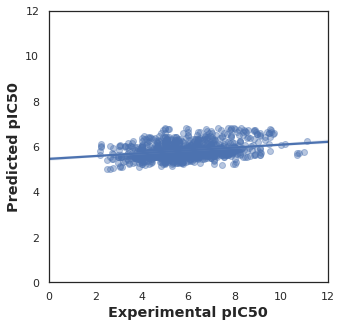

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show